In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd

'/content'

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# This is in my google drive
train_dataset_directory = '/content/drive/MyDrive/Dataset/train/train'
test_dataset_directory = '/content/drive/MyDrive/Dataset/test/test'

training_dataset = image_dataset_from_directory(train_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224),
                                             seed = 42,
                                             subset= 'training',
                                             validation_split=0.2) # 20% of data will be used for validation)                        https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

validation_datset = image_dataset_from_directory(train_dataset_directory,
                                              validation_split=0.2, # 20% of data will be used for validation
                                              subset='validation',
                                              seed=42, # random number shuffler of data. Same as training for consistency
                                              image_size=(224, 224),
                                              batch_size=32)

test_dataset = image_dataset_from_directory(test_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224)) 



class_names = training_dataset.class_names
print(class_names)

Found 993 files belonging to 3 classes.
Using 795 files for training.
Found 993 files belonging to 3 classes.
Using 198 files for validation.
Found 267 files belonging to 3 classes.
['paper', 'plastic', 'trash']


In [4]:
from tensorflow.data.experimental import AUTOTUNE

# Allows the system to automatiucally determine optimal buffer size. May help improve traininng speed
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE) 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential
# data augeentation here. https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

# Data augmentation layers. This does NOT increase the amount of data. Instead it augements on the Fly
# Meaning during training the model will randomly see the data rotated, flipped, zoomed or translated
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomFlip("horizontal"),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])


train_ds = training_dataset.map(lambda images, labels: (data_augmentation(images), labels))

In [6]:
# pre process input 
from tensorflow.keras.applications.efficientnet import preprocess_input

# pre-processes by the mean and standard deviation of certain values, while making the pixels be between [-1,1] See here https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
train_ds = training_dataset.map(lambda images, labels: (preprocess_input(images), labels))
val_ds = validation_datset.map(lambda images, labels: (preprocess_input(images), labels))
test_dataset = test_dataset.map(lambda images, labels: (preprocess_input(images), labels))

In [7]:
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

base_model = EfficientNetB0(weights = "imagenet", include_top=False, 
                         input_shape = (224,224, 3))
base_model.trainable = None

# Create the custom classification layer
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization with weight decay of 0.01
x = Dropout(0.5)(x)  # Dropout regularization with a rate of 0.5
output_layer = Dense(3, activation='softmax')(x)  # 3 classes for your specific problem

new_model = Model(inputs=base_model.input, outputs = output_layer)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [9]:
# Standard params. Adam and sparse loss are community defaults
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = new_model.fit(
    train_ds,
    epochs=19,
    validation_data=val_ds,
    verbose = 2,
    batch_size = len(train_ds)) # uses BGD instead of SGD

Epoch 1/19
25/25 - 16s - loss: 2.5315 - accuracy: 0.7899 - val_loss: 1.9218 - val_accuracy: 0.8889 - 16s/epoch - 651ms/step
Epoch 2/19
25/25 - 4s - loss: 1.6429 - accuracy: 0.9195 - val_loss: 1.3501 - val_accuracy: 0.9040 - 4s/epoch - 157ms/step
Epoch 3/19
25/25 - 4s - loss: 1.1600 - accuracy: 0.9346 - val_loss: 1.0215 - val_accuracy: 0.9040 - 4s/epoch - 144ms/step
Epoch 4/19
25/25 - 3s - loss: 0.8419 - accuracy: 0.9597 - val_loss: 0.7766 - val_accuracy: 0.9242 - 3s/epoch - 118ms/step
Epoch 5/19
25/25 - 3s - loss: 0.6533 - accuracy: 0.9585 - val_loss: 0.6412 - val_accuracy: 0.9242 - 3s/epoch - 122ms/step
Epoch 6/19
25/25 - 4s - loss: 0.5296 - accuracy: 0.9623 - val_loss: 0.5424 - val_accuracy: 0.9242 - 4s/epoch - 147ms/step
Epoch 7/19
25/25 - 4s - loss: 0.4253 - accuracy: 0.9686 - val_loss: 0.4958 - val_accuracy: 0.9141 - 4s/epoch - 164ms/step
Epoch 8/19
25/25 - 3s - loss: 0.3765 - accuracy: 0.9660 - val_loss: 0.4321 - val_accuracy: 0.9242 - 3s/epoch - 124ms/step
Epoch 9/19
25/25 - 3s 

In [11]:
test_loss, test_accuracy = new_model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


9/9 [==============================] - 2s 117ms/step - loss: 0.3273 - accuracy: 0.9401
Test accuracy: 94.01%


In [ ]:
!pip install tensorflow==2.9.1


In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [12]:
# I've had to downgrade the tensorflow version to save the model. https://discuss.tensorflow.org/t/using-efficientnetb0-and-save-model-will-result-unable-to-serialize-2-0896919-2-1128857-2-1081853-to-json-unrecognized-type-class-tensorflow-python-framework-ops-eagertensor/12518/7
new_model.save('/content/drive/MyDrive/efficientnet')
# previous save saved somewhere i dont know

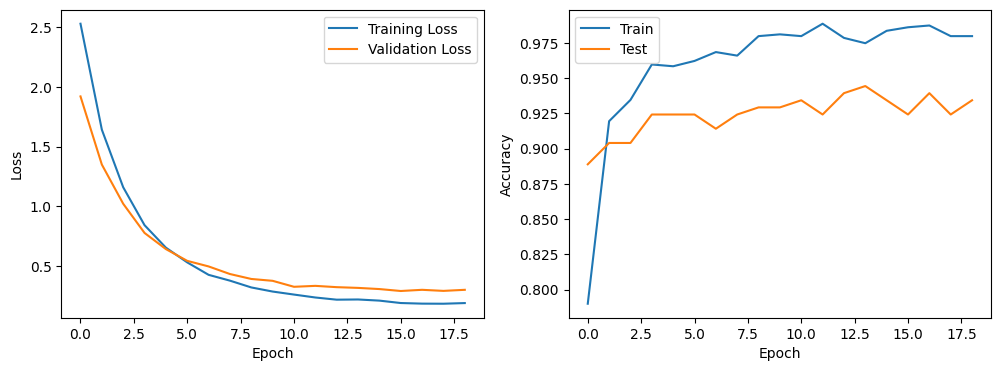

'\nGraph one shows that the model is learning, mbut failed to generalize on the validation.\nThis is a form of overfitting the data. Our model is too complex for our data.\n\nSolutions: Obtain more data to avoid overfitting or perform overfitting techniques\n'

In [13]:
import matplotlib.pyplot as plt

# Plot the training/validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

"""
Graph one shows that the model is learning.
Very unsmooth accuracy data.
"""